In [1]:
import import_ipynb
import os
import sys
import gin
from IPython.core.display import clear_output, display
import sys
sys.path.append('../')
from ariadne.graph_net.graph_utils.graph_prepare_utils import to_pandas_graph_from_df, get_pd_line_graph, \
    apply_nodes_restrictions
from ariadne.transformations import Compose, ConstraintsNormalize, ToCylindrical, DropFakes, DropSpinningTracks, DropShort
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from prepare import parse

csv_params = {
"sep": '\s+',
"nrows": 15000,
"encoding": 'utf-8',
"names": ['event',  'x', 'y', 'z', 'station', 'track', 'px', 'py', 'pz', 'X0', 'Y0', 'Z0']
}
suff_df = ('_p', '_c')

stations_constraints = {
    0: {'r': [-167., 167.], 'phi': [-3.15, 3.15], 'z': [-423.5, 423.5]},
    1: {'r': [-167., 167.], 'phi': [-3.15, 3.15], 'z': [-423.5, 423.5]},
    2: {'r': [-167., 167.], 'phi': [-3.15, 3.15], 'z': [-423.5, 423.5]},
}




In [3]:
## parse df
events = parse("../data/new_data/1.txt", csv_params=csv_params, events_quantity='0..300')

In [4]:
import pandas as pd

In [8]:
for event in events:
    print(event.head())

In [9]:
events = pd.read_table("../data/new_data/1.txt", names=['event',  'x', 'y', 'z', 'station',
                               'track', 'px', 'py', 'pz', 'X0', 'Y0', 'Z0'], sep='\s+')

In [13]:
events = events[events.event < 300]
for idx, event in events.groupby('event'):
    clear_output(wait=True)
    display("Event #%09d" % idx)

    transformer = Compose([
            DropFakes(),
            DropSpinningTracks(),
            DropShort(),
            ToCylindrical(),
            ConstraintsNormalize(
                use_global_constraints=False,
                constraints=stations_constraints,
                columns=('r', 'phi', 'z')
            ),
        ])
    try:
        event = transformer(event)
    except AssertionError as err:
        print("ASS error %r" % err)
        continue
    

'Event #000000298'

{0: {'r': [-167.0, 167.0], 'phi': [-3.15, 3.15], 'z': [-423.5, 423.5]}, 1: {'r': [-167.0, 167.0], 'phi': [-3.15, 3.15], 'z': [-423.5, 423.5]}, 2: {'r': [-167.0, 167.0], 'phi': [-3.15, 3.15], 'z': [-423.5, 423.5]}}


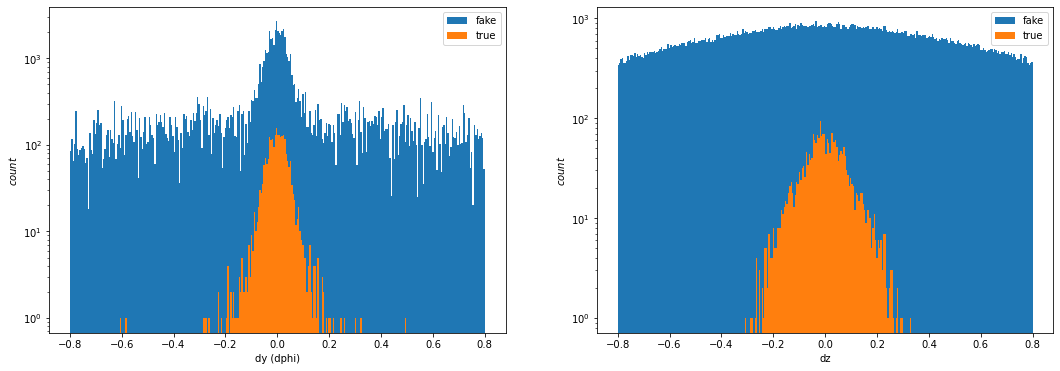

In [8]:
true_nodes = nodes[nodes.track != -1]
fake_nodes = nodes[nodes.track == -1]

plt.figure(figsize=(18,6))

plt.subplot(121)
binning=dict(bins=300, range=(-0.8, 0.8))
plt.hist(fake_nodes.dy, label='fake', log=True, **binning)
plt.hist(true_nodes.dy, label='true', **binning)
#plt.axvline(-0.15, color='yellow', linestyle='dashed', linewidth=3)
#plt.axvline(0.15, color='yellow', linestyle='dashed', linewidth=3)
plt.ylabel('$count$')
plt.xlabel('dy (dphi)')
plt.legend(loc=0)

plt.subplot(122)
binning=dict(bins=300, range=(-0.8, 0.8))
plt.hist(fake_nodes.dz, label='fake', log=True, **binning)
plt.hist(true_nodes.dz, label='true', **binning)
#plt.axvline(-0.15, color='yellow', linestyle='dashed', linewidth=3)
#plt.axvline(0.15, color='yellow', linestyle='dashed', linewidth=3)
plt.ylabel('$count$')
plt.xlabel('dz')
plt.legend(loc=0)

In [10]:
def calc_purity_reduce_factor(df_full, df_filtered, true_label = 'true_superedge', cmp_with=-1):
    assert true_label in df_full and true_label in df_filtered

    return len(df_filtered[df_filtered[true_label] != cmp_with]) / len(df_full[df_full[true_label] != cmp_with]), len(df_full) / len(df_filtered)

In [34]:
def filter_segments(df, dphi_min, dphi_max, dz_min, dz_max):
    return df[
        (df.dy > dphi_min) & (df.dy < dphi_max) &
        (df.dz > dz_min) & (df.dz < dz_max)
    ]


dphi_minmax = (-0.2, 0.2)
dz_minmax = (-0.28, 0.28)
segments = nodes
filtered = filter_segments(segments, *dphi_minmax, *dz_minmax)

purity_, reduce_ = calc_purity_reduce_factor(segments, filtered, 'track', -1)
print("Initial fake to real ratio is %.6f" % (len(segments) / len(segments[segments.track != -1])))
print("Currently fake to real ratio is %.6f" % (len(filtered) / len(filtered[filtered.track != -1])))
print("Result purity %.3f; segments filtering reduced ratio in %.3f times" % (purity_, reduce_))

Initial fake to real ratio is 98.113562
Currently fake to real ratio is 9.168247
Result purity 0.991; segments filtering reduced ratio in 10.803 times


In [36]:
def apply_edge_restriction(pd_edges_df, RESTRICTION=0.15):
    assert 'weight' in pd_edges_df
    return pd_edges_df[pd_edges_df.weight < RESTRICTION]


filtered = apply_edge_restriction(edges, 0.093)

purity_, reduce_ = calc_purity_reduce_factor(edges, filtered, 'true_superedge', -1)
print("Initial fake to real ratio is %.6f" % (len(edges) / len(edges[edges.true_superedge != -1])))
print("Currently fake to real ratio is %.6f" % (len(filtered) / len(filtered[filtered.true_superedge != -1])))
print("Result purity %.3f; segments filtering reduced ratio in %.3f times" % (purity_, reduce_))

Initial fake to real ratio is 3038.049044
Currently fake to real ratio is 11.052897
Result purity 0.990; segments filtering reduced ratio in 277.634 times
